# Langchain & Python #

https://www.itworld.co.kr/news/307189 

In [16]:
!pip install -q grobid-client langchain openai faiss-cpu PyPDF2 tiktoken

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


In [2]:
pip install --upgrade pip

DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Note: you may need to restart the kernel to use updated packages.


In [3]:
import openai
from PyPDF2 import PdfReader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import CharacterTextSplitter
from langchain.vectorstores import ElasticVectorSearch, Pinecone, Weaviate, FAISS
import os

os.environ["OPENAI_API_KEY"] = "sk-I"  #개인 gpt api

#https://platform.openai.com/account/api-keys

In [4]:
reader = PdfReader("혼인.pdf")

raw_text = ""

for i, page in enumerate(reader.pages):
    text = page.extract_text()
    if text:
        raw_text += text

raw_text[:1000]

'함께저희가 부부가되는 오늘 이 자리에서 부모님과 참석하신 여러분께 다음을 선약합니다신랑오늘 저 석현진은 이 시간 가장 소중하고 아름다운 장현지를 아내로 맞이합니다.현지의 아름다운 미소가 저를 설레이게 하였고서로를 바라보는 것만으로도 행복한 일임을 알게 해주었습니다.어렵고 힘든 순간이 다가올지라도언제나 기댈 수 있는 안식처가 되어 늘 곁에 있으며,현지를 영원히 사랑하며 살 것을이 자리에 계신 소중한 분들 앞에서 진심으로 서약합니다.신부오늘 저 장현지는 이 시간 가장 소중하고 멋진 석현진 남편으로 맞이합니다.기쁘고 즐거운 시간뿐만 아니라 힘들고 지칠때도 언제나 나의 곁에서 잔잔한 파도같은 사랑으로 한결같이 굳게 함께해준 당신에게 감사의 마음을 전하며 우리의 소중한 시간을 항상 기억하겠습니다.지금 이 마음 그대로 평생 함께 할 것을이 자리에 계신 소중한 분들 앞에서 진심으로 서약합니다.함께신랑 이렇게 아름다운 아내 장현지와'

# 챗봇 #

In [5]:
from langchain import OpenAI
from langchain.chains import AnalyzeDocumentChain
from langchain.chains.summarize import load_summarize_chain

llm = OpenAI(temperature=0)
summary_chain = load_summarize_chain(llm, chain_type="map_reduce")

summarize_document_chain = AnalyzeDocumentChain(combine_docs_chain=summary_chain)

In [6]:
summarize_document_chain.run(raw_text)

'\n\n장현진과 석현진이 오늘 부모님과 참석한 여러분 앞에서 부부가 되는 것을 선약합니다. 석현진은 장현진의 미소로 설레임을 느끼고, 기댈 수 있는 안식처가 되기를 기대합니다.'

In [7]:
from langchain.chains.question_answering import load_qa_chain
from langchain.chat_models import ChatOpenAI

model = ChatOpenAI(model="gpt-3.5-turbo") # gpt-3.5-turbo, gpt-4

qa_chain = load_qa_chain(model, chain_type="map_reduce")
qa_document_chain = AnalyzeDocumentChain(combine_docs_chain=qa_chain)

In [8]:
qa_document_chain.run(
    input_document=raw_text,
    question='사람의 이름은?')

'제가 알고 있는 정보로는 장현지라는 이름을 가진 사람이 있습니다.'

In [9]:
qa_document_chain.run(
    input_document=raw_text,
    question="석현진이 반한것은?")

'석현진이 장현지의 아름다운 미소에 반해 저를 설레이게 했다고 언급되어 있습니다.'

In [10]:
qa_document_chain.run(
    input_document=raw_text,
    question="참석한 사람은?")

'부모님과 여러분이 참석하셨습니다.'

# 분석 #

In [12]:
import pandas as pd
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent
#https://python.langchain.com/docs/integrations/toolkits/pandas 업데이트 확인
#pip install tabulate 설치 테이블 (표)

from langchain.chat_models import ChatOpenAI
from langchain.agents.agent_types import AgentType

df = pd.read_csv("train.csv") #타이타닉 데이터 활용

df.head()
df.info

<bound method DataFrame.info of      PassengerId  Pclass  Sex   Age  SibSp  Parch     Fare  Survived
0              1       3    0  22.0      1      0   7.2500         0
1              2       1    1  38.0      1      0  71.2833         1
2              3       3    1  26.0      0      0   7.9250         1
3              4       1    1  35.0      1      0  53.1000         1
4              5       3    0  35.0      0      0   8.0500         0
..           ...     ...  ...   ...    ...    ...      ...       ...
886          887       2    0  27.0      0      0  13.0000         0
887          888       1    1  19.0      0      0  30.0000         1
888          889       3    1   NaN      1      2  23.4500         0
889          890       1    0  26.0      0      0  30.0000         1
890          891       3    0  32.0      0      0   7.7500         0

[891 rows x 8 columns]>



> Entering new AgentExecutor chain...
Thought: 데이터 프레임의 모든 독립변수를 분석해야 한다.
Action: python_repl_ast
Action Input: df.corr()
Observation:              PassengerId    Pclass       Sex       Age     SibSp     Parch  \
PassengerId     1.000000 -0.035144 -0.042939  0.036847 -0.057527 -0.001652   
Pclass         -0.035144  1.000000 -0.131900 -0.369226  0.083081  0.018443   
Sex            -0.042939 -0.131900  1.000000 -0.093254  0.114631  0.245489   
Age             0.036847 -0.369226 -0.093254  1.000000 -0.308247 -0.189119   
SibSp          -0.057527  0.083081  0.114631 -0.308247  1.000000  0.414838   
Parch          -0.001652  0.018443  0.245489 -0.189119  0.414838  1.000000   
Fare            0.012658 -0.549500  0.182333  0.096067  0.159651  0.216225   
Survived       -0.005007 -0.338481  0.543351 -0.077221 -0.035322  0.081629   

                 Fare  Survived  
PassengerId  0.012658 -0.005007  
Pclass      -0.549500 -0.338481  
Sex          0.182333  0.543351  
Age          0.096067 -0

'생존에 가장 많이 영향을 미친 독립변수는 성별이며, 이를 보여주는 그래프는 위에서 만든 AxesSubplot(0.125,0.125;0.775x0.755) 입니다.'

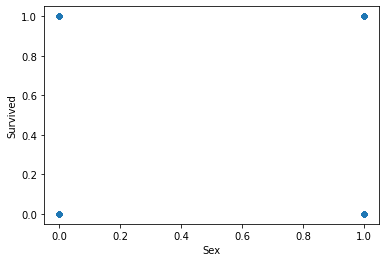

In [19]:
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), df, verbose=True)
agent.run("생존에 영향을 가장 많이준 독립변수는? 그래프") #질문

In [20]:
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), df, verbose=True)
agent.run("랜덤포레스트 예측 모델 코드") #질문



> Entering new AgentExecutor chain...
Thought: 랜덤포레스트는 머신러닝 모델로 데이터를 분류하기 위해 사용됩니다.
Action: python_repl_ast
Action Input: from sklearn.ensemble import RandomForestClassifier
Observation: 
Thought: 모델을 만들기 위해 데이터를 준비해야합니다.
Action: python_repl_ast
Action Input: X = df.drop(['Survived'], axis=1)
Observation: 
Thought: 목표 변수를 준비합니다.
Action: python_repl_ast
Action Input: y = df['Survived']
Observation: 
Thought: 모델을 만듭니다.
Action: python_repl_ast
Action Input: model = RandomForestClassifier()
Observation: 
Thought: 모델을 훈련합니다.
Action: python_repl_ast
Action Input: model.fit(X, y)
Observation: ValueError: Input X contains NaN.
RandomForestClassifier does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop sam

"from sklearn.ensemble import RandomForestClassifier\nX = df.drop(['Survived'], axis=1)\ny = df['Survived']\nfrom sklearn.impute import SimpleImputer\nimputer = SimpleImputer(strategy='mean')\nX = imputer.fit_transform(X)\nmodel = RandomForestClassifier()\nmodel.fit(X, y)"



> Entering new AgentExecutor chain...
Thought: age와 survived 사이의 관계를 보기 위해 산점도 그래프를 그릴 필요가 있다.
Action: python_repl_ast
Action Input: df.plot.scatter(x='Age', y='Survived')
Observation: AxesSubplot(0.125,0.125;0.775x0.755)
Thought: 그래프가 그려졌으므로 이제 결과를 확인할 수 있다.
Final Answer: age와 survived 사이의 관계를 보여주는 산점도 그래프가 그려졌다.

> Finished chain.


'age와 survived 사이의 관계를 보여주는 산점도 그래프가 그려졌다.'

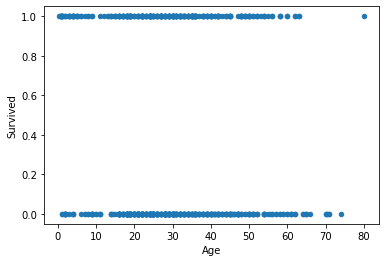

In [23]:
agent = create_pandas_dataframe_agent(OpenAI(temperature=0), df, verbose=True)
agent.run("age 산점도 그래프") #질문